In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pickle
import os
import matplotlib.pyplot as plt
from tqdm import trange

## Neural Network (Multilayer Perceptron) Written From Scratch

This code is a simple implementation of a Multilayer Perceptron. It utilizes several different activation functions and loss functions, and includes a linear layer where you can specify the input and output feature sizes. The NeuralNetwork class is then defined based on these components.

The code uses the `NumPy` library to perform matrix calculations efficiently and employs `pandas` DataFrames to manage datasets. At the end, the model is tested on the `Fashion-MNIST` dataset, which consists of 28×28 pixel images of clothing items along with their corresponding labels. The model successfully learns to classify the images with an accuracy of approximately 98.5%. The dataset is loaded using `pickle`, so there's no need to re-download the data each time the code is executed.

### Activation Layers
Activation functions are used to introduce non-linearity into neural networks. If you think about a perceptron, it’s essentially a simple linear equation:
$$z=wx+b$$

where $w$ is the weight and $b$ is the bias.

If you perform multiple forward passes through linear layers, the output of the final layer ends up being just another linear function of the input. Mathematically, you'd get something like:

$$z_k = w_k(w_{k-1}(w_{k_2}(...(w_1x+b_1))+b_{k_2})+b_{k-1})+b_k$$

This entire expression can be reduced to a single linear equation:
$$z_k​=w^′x+b^′$$
Since the composition of linear functions is still linear, this limits the network’s ability to learn complex patterns or capture meaningful representations.

To overcome this limitation, we apply a non-linear activation function after each layer, transforming the output of each perceptron:
$$ai​=σ(wx+b)$$
Here, $\sigma$ could be a sigmoid, ReLU, or any other activation function. This non-linearity allows the network to approximate highly complex and non-linear functions.

##### ReLU
ReLU stands for **Rectified Linear Unit**, It's one of the most commonly used activation functions in modern neural networks.

The function is defined as:
$$\text{ReLU}(x) = \max{(0,x)}$$

It's derivitive for backward pass is calculated like this:
$$\text{ReLU}'(x)= \left\{\begin{matrix}
1 & \text{if} ~~ x > 0 \\
0 &  \text{otherwise} \\
\end{matrix}\right.$$

In [2]:
class ReLU():
    def forward(self, inp: np.ndarray) -> np.ndarray:
        self.inp = inp
        self.out = np.maximum(0, inp)
        return self.out

    def backward(self, Delta: np.ndarray) -> np.ndarray:
        downDelta = Delta * (self.inp > 0)
        return downDelta

##### Softmax

Softmax is an activation function that turns a vector of real numbers into a probability distribution meaning:

- All output values are between 0 and 1.
- The sum of all outputs is exactly 1.

Given an input vector $\mathbf{z} = [z_1, z_2, \dots, z_n]$, the softmax function is defined as:
$$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}$$

There is one important thing to consider, Exponintials can get *huge*, so in real implementations, we subtract the maximum value from the input vector before applying softmax:

$$\text{Softmax}(z_i) = \frac{e^{z_i - \max(z)}}{\sum_{j=1}^n e^{z_j - \max(z)}}$$


It's derivitive is calculated via Jacobian matrix of softmax:
$$
J_{ij} = \frac{\partial \sigma_i}{\partial z_j} = 
\left\{\begin{matrix}
\sigma_i(1-\sigma_i) & \text{if} ~~ i = j \\
-\sigma_i\sigma_j &  i \ne j\\
\end{matrix}\right.
$$

In [3]:
class Softmax():
    def forward(self, inp) -> np.ndarray:
        self.inp = inp
        exp_values = np.exp(inp - np.max(inp, axis=1, keepdims=True))
        self.out = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return self.out
    
    def backward(self, Delta) -> np.ndarray:
        downDelta = np.empty_like(Delta)
        for i in range(Delta.shape[0]):
            single_output = self.out[i].reshape(-1, 1)
            jacobian = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            downDelta[i] = np.dot(jacobian, Delta[i])
        return downDelta


### Loss Functions

To improve a model, we first need a way to measure how poorly it's performing. That’s exactly what a **loss function** does. Once we can quantify the error, it becomes a matter of minimizing this loss using optimization algorithms—and there are many types of loss functions depending on the task.

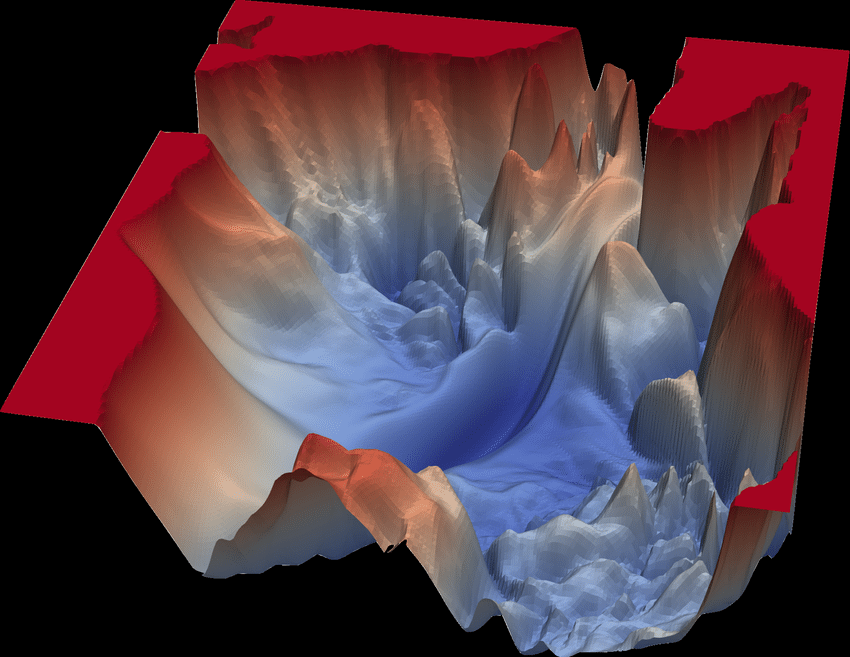

As you can see, the surface of a loss function can be incredibly complex. Also, loss functions don’t necessarily depend on just two parameters. In fact, their parameters are the actual weights and biases of the neural network:

$\text{Loss}(w_1, w_2, \dots, b_1, b_2, \dots) = \dots$

So we’re dealing with a high-dimensional and highly non-linear function. The go-to algorithm for minimizing such a function is **gradient descent**, which, surprisingly, is quite simple.

The **gradient** of a function is a vector that points in the direction of steepest increase. That means if we go in the *opposite* direction, we’re moving toward the steepest decrease—perfect for minimizing a loss.

To compute the gradient, we take the **partial derivatives** of the loss function with respect to each parameter:

$$
\nabla \text{Loss}(w_1, w_2, \dots, b_1, b_2, \dots) = 

\begin{pmatrix}
    \frac{\partial \text{loss}}{\partial w_1} \\
    \frac{\partial \text{loss}}{\partial w_2} \\
    \dots \\
    \frac{\partial \text{loss}}{\partial b_1} \\
    \frac{\partial \text{loss}}{\partial b_2} \\
    \dots 
\end{pmatrix}

$$

To reduce the loss, we update each parameter by moving it in the direction that decreases the loss:

$$
w_i \leftarrow w_i - \alpha \frac{\partial \text{loss}}{\partial w_i}
$$

$$
b_i \leftarrow b_i - \alpha \frac{\partial \text{loss}}{\partial b_i}
$$

Here, $\alpha$ is called the **learning rate**. It's a small coefficient that controls the step size. A good way to visualize this is to imagine dropping a ball on the surface of the loss function. Gradient descent acts like gravity, pulling the ball downward. However, the ball might get stuck in a **local minimum** instead of reaching the **global minimum**.

So how do we increase our chances of escaping local minima? If the ball has a little bounce, **not too much though**, it can potentially escape shallow local traps and continue toward a better minimum. That’s the role of the learning rate. it helps balance progress with stability.


### 🎯 Mean Squared Error (MSE)

The **Mean Squared Error (MSE)** is one of the most commonly used loss functions, especially in regression problems.

It measures the average of the **squared** differences between the predicted values and the actual (true) values.

If your model predicts values $\hat{y}_1, \hat{y}_2, \dots, \hat{y}_n$ and the true values are $y_1, y_2, \dots, y_n$, then the MSE is defined as:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Here:

* $y_i$ = true value
* $\hat{y}_i$ = predicted value
* $n$ = total number of samples

Why do we square the error? So we penalize **larger errors** more heavily and avoid negative errors canceling out positive ones.

### Derivative of MSE


$$
\nabla_{\hat{y}} \text{MSE} = \frac{2}{n} (\hat{y} - y)
$$

So during backpropagation, we use this to update the model parameters via gradient descent.



In [4]:
class MSE():
    def forward(self, logits, target) -> float:
        self.logits = logits
        self.target = target
        self.loss = np.mean((self.logits - self.target) ** 2)
        return self.loss
    
    def backward(self) -> np.ndarray:
        downDelta = (2 / self.target.size) * (self.logits - self.target)
        return downDelta

### Softmax Cross-Entropy Loss Function

The **Softmax Cross-Entropy Loss** is a commonly used loss function in multi-class classification tasks. It combines two operations: the **Softmax activation function**, which converts raw model outputs (logits) into probabilities, and the **Cross-Entropy loss**, which measures the discrepancy between the predicted probability distribution and the true class labels.


#### Cross-Entropy Loss

Let $\mathbf{y} = [y_1, y_2, \dots, y_C]$ be the **true class distribution**, typically represented as a one-hot encoded vector (i.e., $y_k = 1$ for the correct class $k$, and $y_j = 0$ for $j \ne k$).

The **cross-entropy loss** between the true distribution $\mathbf{y}$ and the predicted distribution $\hat{\mathbf{y}}$ is defined as:

$$
\mathcal{L}(\hat{\mathbf{y}}, \mathbf{y}) = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

In the one-hot case, this simplifies to:

$$
\mathcal{L} = -\log(\hat{y}_k)
$$

where $k$ is the index of the true class.


#### Gradient of the Softmax Cross-Entropy Loss

Let the original input to the softmax layer be $z_i$, and let the true label be one-hot encoded as before. When combining the softmax function and the cross-entropy loss, the derivative of the loss with respect to each logit $z_i$ simplifies significantly:

$$
\frac{\partial \mathcal{L}}{\partial z_i} = \hat{y}_i - y_i
$$

This elegant result is due to the fact that the derivative of the softmax and the derivative of the log loss combine to cancel out the more complex terms, yielding a simple and computationally efficient expression for backpropagation.



In [5]:
class SoftMaxCrossEntropy():
    def forward(self, logits, target) -> float:
        sm = Softmax()
        self.logits = sm.forward(logits)
        self.target = target

        log_probs = np.log(self.logits + 1e-9) # avoid log(0)
        self.loss = -np.mean(np.sum(self.target * log_probs, axis=1))
        
        return self.loss
    
    def backward(self):
        downDelta = (self.logits - self.target) / self.target.shape[0]
        return downDelta

In [6]:
class CrossEntropy():
    def forward(self, logits, target) -> float:
        self.logits = logits
        self.target = target
        clipped_pred = np.clip(logits, 1e-12, 1.0)
        self.loss = -np.mean(np.sum(target * np.log(clipped_pred), axis=1))
        return self.loss

    def backward(self) -> np.ndarray:
        grad = -self.target / self.logits / self.target.shape[0]
        return grad

### Single Layer Class

### **Structure of a Single Neural Layer**

A single fully connected (dense) layer in a neural network performs an **affine transformation** followed by, optionally, a non-linear activation. In this case, the focus is solely on the affine part.

Let’s denote:

* $\mathbf{X} \in \mathbb{R}^{N \times D_{\text{in}}}$: the input matrix, where each row is an input sample,
* $\mathbf{W} \in \mathbb{R}^{D_{\text{in}} \times D_{\text{out}}}$: the weight matrix,
* $\mathbf{b} \in \mathbb{R}^{1 \times D_{\text{out}}}$: the bias vector.


### **Forward Propagation**

The forward computation of this layer is:

$$
\mathbf{Y} = \mathbf{X} \mathbf{W} + \mathbf{b}
$$

This represents a linear transformation of the input data:

* Each output dimension is a **weighted sum** of the input features plus a bias term.
* This transformation projects the input from $\mathbb{R}^{D_{\text{in}}}$ to $\mathbb{R}^{D_{\text{out}}}$, allowing the model to learn new representations.


### **Backward Propagation**

In the backward pass, we compute the gradients needed for learning, based on the derivative of a loss function $L$ with respect to the layer's outputs.

Let $\Delta = \frac{\partial L}{\partial \mathbf{Y}} \in \mathbb{R}^{N \times D_{\text{out}}}$ be the incoming gradient from the next layer.

#### **Gradient w\.r.t. Weights**:

$$
\frac{\partial L}{\partial \mathbf{W}} = \mathbf{X}^\top \Delta
$$

This uses the **chain rule** and reflects how the loss changes with respect to each weight, averaged over all samples.

#### **Gradient w\.r.t. Biases**:

$$
\frac{\partial L}{\partial \mathbf{b}} = \sum_{i=1}^{N} \Delta_i
$$

Each row of $\Delta$ contributes equally to the bias gradient since $\mathbf{b}$ is added to each output row identically.

#### **Gradient w\.r.t. Input (for previous layer)**:

$$
\frac{\partial L}{\partial \mathbf{X}} = \Delta \mathbf{W}^\top
$$

This is needed to propagate the error backward through the network during training.


### **Parameter Update (Gradient Descent)**

To minimize the loss, we update the weights and biases using gradient descent:

$$
\mathbf{W} := \mathbf{W} - \eta \frac{\partial L}{\partial \mathbf{W}}, \quad
\mathbf{b} := \mathbf{b} - \eta \frac{\partial L}{\partial \mathbf{b}}
$$

Here $\eta$ is the **learning rate**, which determines the step size of the update.


### **Initialization Reasoning**

Weights are initialized from a small random distribution (e.g., normal with small variance) to:

* Break symmetry across neurons,
* Prevent vanishing/exploding gradients (depending on the scale).

Biases are often initialized to zero, as they do not affect symmetry in the same way weights do.


### **Conceptual Goal**

This layer’s goal is to **linearly transform** input features into a new space that enables the network to learn useful patterns through multiple layers. It's the building block of learning hierarchical and abstract representations in neural networks.


In [7]:
class Layer():
    def __init__(self, inp_features: int, out_features: int) -> None:
        self.w = 0.1 * np.random.randn(inp_features, out_features) # He initialization
        self.b = np.zeros((1, out_features))    
        self.dw = np.zeros_like(self.w)
        self.db = np.zeros_like(self.b)
    
    def forward(self, inp: np.ndarray) -> np.ndarray:
        self.inp = inp
        self.out = np.dot(inp, self.w) + self.b
        return self.out
    
    def backward(self, Delta):
        self.dw = np.dot(self.inp.T, Delta)  
        self.db = np.sum(Delta, axis=0, keepdims=True) 
        return np.dot(Delta, self.w.T)

    def update(self, learning_rate: float):
        self.w -= (learning_rate * self.dw)
        self.b -= (learning_rate * self.db)

### Multilayer Perceptron (MLP)

A **feedforward neural network** is a function:

$$
f(\mathbf{x}; \theta) : \mathbb{R}^{D_{\text{in}}} \to \mathbb{R}^{D_{\text{out}}}
$$

constructed by **composing multiple affine transformations** (layers) and optionally applying non-linearities in between.


### **1. Forward Propagation**

Given an input batch $\mathbf{X} \in \mathbb{R}^{N \times D_{\text{in}}}$, the data is passed through a sequence of layers:

$$
\mathbf{Z}^{(1)} = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)} \\
\mathbf{A}^{(1)} = \phi^{(1)}(\mathbf{Z}^{(1)})
$$

$$
\mathbf{Z}^{(2)} = \mathbf{A}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)} \\
\mathbf{A}^{(2)} = \phi^{(2)}(\mathbf{Z}^{(2)})
$$

$$
\cdots
$$

$$
\hat{\mathbf{Y}} = \mathbf{A}^{(L)} = f(\mathbf{X})
$$

Each layer takes the output of the previous one and transforms it via:

* a **linear transformation** (matrix multiplication and bias addition),
* followed by a **non-linear activation function** $\phi$ .

This forms a **compositional function**:

$$
\hat{\mathbf{Y}} = f(\mathbf{X}) = \phi^{(L)} \circ \dots \circ \phi^{(1)} \left( \mathbf{X} \right)
$$


### **2. Loss Function**

Given true labels $\mathbf{Y} \in \mathbb{R}^{N \times D_{\text{out}}}$, the model computes a scalar loss:

$$
\mathcal{L}(\mathbf{Y}, \hat{\mathbf{Y}})
$$

This measures the difference between predictions and targets. Examples include:

* MSE for regression,
* Cross-entropy for classification.


### **3. Backpropagation (Gradient Computation)**

To update the parameters and minimize the loss, we compute gradients using the **chain rule** of calculus. For each parameter $\theta_k \in \theta$, we compute:

$$
\frac{\partial \mathcal{L}}{\partial \theta_k}
$$

Backpropagation proceeds **layer by layer in reverse order**, computing:

$$
\delta^{(L)} = \frac{\partial \mathcal{L}}{\partial \mathbf{A}^{(L)}}
$$

$$
\delta^{(l)} = \left( \delta^{(l+1)} \cdot \frac{\partial \mathbf{A}^{(l+1)}}{\partial \mathbf{Z}^{(l+1)}} \right) \cdot \mathbf{W}^{(l+1)\top}
$$

This gives the gradients:

* $\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{(l)}} = \mathbf{A}^{(l-1)\top} \cdot \delta^{(l)}$
* $\frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(l)}} = \sum \delta^{(l)}$

These partial derivatives tell us **how sensitive the loss is** to each parameter.


### **4. Training Loop**

Training is done over multiple **epochs**, where in each epoch:

1. The dataset is split into **mini-batches** of size $B$.
2. For each batch:

   * Compute predictions: $\hat{\mathbf{Y}} = f(\mathbf{X})$
   * Compute loss: $\mathcal{L}(\mathbf{Y}, \hat{\mathbf{Y}})$
   * Compute gradients via backpropagation
   * Update all parameters

This repeated optimization process allows the network to gradually approximate the function that maps inputs to correct outputs.


### **5. Accuracy Evaluation**

For classification tasks, we often compute accuracy:

$$
\text{accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1} \left[ \arg\max_k \hat{y}_{ik} = \arg\max_k y_{ik} \right]
$$

Where:

* $\hat{y}_{ik}$: predicted probability for class $k$,
* $y_{ik}$: one-hot encoded ground truth label.

This measures the proportion of correct predictions.



In [8]:
class NeuralNetwork():
    def __init__(self, layers: list, lossFunction, learning_rate: float) -> None:
        self.lossFunction = lossFunction
        self.layers = layers
        self.learning_rate = learning_rate
        
    def forward(self, inp: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            inp = layer.forward(inp)
        return inp
    
    def backward(self):
        last_delta = self.lossFunction.backward()
        for layer in reversed(self.layers):
            last_delta = layer.backward(last_delta)
    
    def update(self):
        for layer in self.layers:
            if isinstance(layer, Layer):
                layer.update(self.learning_rate)

    def loss(self, logits: np.ndarray, target: np.ndarray) -> float:
        return self.lossFunction.forward(logits, target)

    def accuracy(self, preds, target):
        return np.mean(np.argmax(preds, axis=1) == np.argmax(target, axis=1))

    def train(self, x: np.ndarray, y:np.ndarray, epochs: int, batch: int):
        print("Initiating training...")
        losses = np.empty(epochs)
        for e in (pbar := trange(epochs)):

            running_loss = 0.0
                
            for i in range(0, len(x), batch):

                x_batch = x[i:i + batch]
                y_batch = y[i:i + batch]

                logits = self.forward(x_batch)
                running_loss += self.loss(logits, y_batch) * batch
                self.backward()
                self.update()
                
            running_loss /= len(x)
            pbar.set_description(f"Loss: {running_loss:.3f}")
            losses[e] = running_loss

        print("Training Finished")
        return losses

### Data Prepration

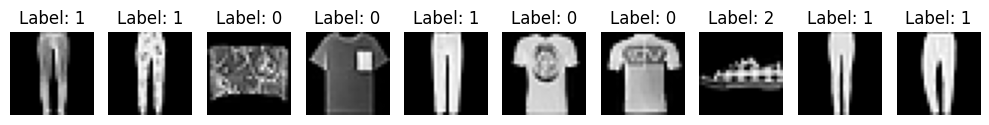

(11000, 784) (11000, 3)


In [9]:

def one_hot_key_encoding(inp: pd.Series, size):
        one_hot = np.zeros(shape=(inp.size, size), dtype=int)
        one_hot[np.arange(inp.size), inp] = 1
        return one_hot

def get_data(filter_classes, cache_path="fashion_data.pkl"):
    # If the dataset already exists, load it
    if os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            return pickle.load(f)

    # Otherwise download it and process
    fashion_mnist = fetch_openml("Fashion-MNIST", parser='auto')
    x, y = fashion_mnist['data'], fashion_mnist['target'].astype(int)

    # Filter classes
    filtered_indices = np.isin(y, filter_classes)
    x, y = x[filtered_indices].to_numpy(), y[filtered_indices]

    # Normalize the pixels to [-1, +1]
    x = ((x / 255.) - .5) * 2

    # Relabel classes
    removed_class_count = 0
    for i in range(10):
        if i in filter_classes and removed_class_count != 0:
            y[y == i] = i - removed_class_count
        elif i not in filter_classes:
            removed_class_count += 1

    # Train/test split
    data = train_test_split(x, y, test_size=10_000)

    # Save the processed data
    with open(cache_path, "wb") as f:
        pickle.dump(data, f)

    return data

class_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
               3: 'Dress', 4: 'Coat', 5:  'Sandal', 6: 'Shirt',
               7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

# Include all the classes you want to see in training
kept_classes = [0, 1, 2]  # T-shirt/top, Trouser, Pullover

# Download the dataset and split it into training and testing sets
x_train, x_test, y_train, y_test = get_data(kept_classes)


df_x = pd.DataFrame(x_train)
def show_images(n = 10):
    plt.figure(figsize=(n,2))
    for i in range(n):
        image = df_x.iloc[i].values.reshape(28,28)
        label = y_train.iloc[i]
        plt.subplot(1, n, i+1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_images()


y_train = one_hot_key_encoding(y_train, len(kept_classes))

def plot_training(losses):
    # Plot the loss
    plt.plot(losses)
    plt.title("Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

print(x_train.shape, y_train.shape)

### Training


## **Fashion-MNIST (Subset of 3 Classes)**

Fashion-MNIST is a benchmark dataset for image classification tasks, consisting of grayscale clothing images of size $28 \times 28$, which are typically flattened into vectors in $\mathbb{R}^{784}$. In this case, only **3 classes** (a subset of the original 10) are used for classification, which simplifies the task into a **3-way multi-class classification** problem.

The task is to learn a mapping:

$$
f: \mathbb{R}^{784} \rightarrow \{0, 1, 2\}
$$

that can assign a label to each input image with high confidence and generalization to unseen data.


## **Choice of Network Architecture**

The network architecture consists of:

* **Input Layer (784 → 50)**: Reduces the high-dimensional input space to a lower-dimensional latent space. This step acts as a feature extractor, compressing raw pixel data into a more compact and informative representation.

* **Hidden Layer (50 → 50)**: Provides additional capacity for learning **nonlinear combinations of features**. It enables the network to model more complex patterns such as textures or shape compositions.

* **Output Layer (50 → 3)**: Outputs three scores (logits), one for each class. These are transformed into class probabilities using the **softmax function**.

* **Activation Function**: ReLU is applied after the first two layers to introduce non-linearity and prevent the network from collapsing into a simple linear model. This allows the network to approximate complex decision boundaries between classes.

* **Loss Function**: Softmax cross-entropy loss is used, which is well-suited for multi-class classification tasks with one-hot encoded labels. It penalizes incorrect predictions more strongly the more confident they are.


## **Justification of the Architecture**

* **Compactness**: The architecture is intentionally lightweight, with just two hidden layers of moderate width. This is sufficient due to the limited complexity of Fashion-MNIST and the use of only three classes.

* **Efficiency**: The design ensures fast training and low risk of overfitting, especially with a relatively small dataset and fewer classes.

* **Capacity–Data Balance**: The number of parameters is appropriate for the scale of the task — it has enough capacity to learn discriminative features without being unnecessarily deep or wide.


## **Performance**

After training for 30 epochs with a batch size of 64 and a learning rate of 0.001, the network reaches a **test accuracy of 98%**. This high level of performance demonstrates that:

* The chosen architecture is **well-suited** to the task,
* The network generalizes well to unseen data, and
* The learned representations are sufficient to **linearly separate** the three classes in the transformed feature space.



(11000, 784) 11000
Initiating training...


Loss: 0.046: 100%|██████████| 30/30 [00:02<00:00, 12.02it/s]


Training Finished


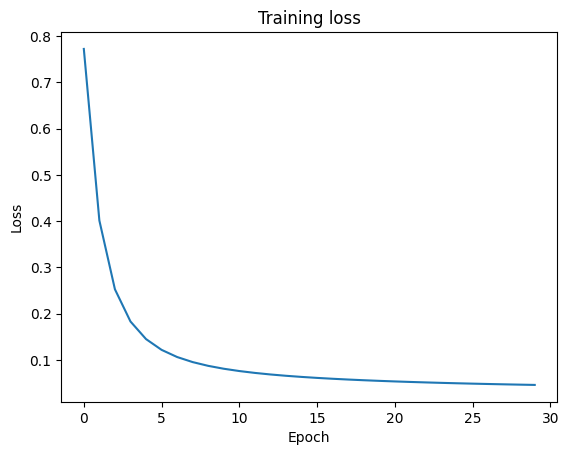

Test accuracy with 11000 training examples on 10000 test samples is 98.62%


In [10]:
layers = [
    Layer(784, 50),
    ReLU(),
    Layer(50, 50),
    ReLU(),
    Layer(50,len(kept_classes)),
]


nn = NeuralNetwork(layers, SoftMaxCrossEntropy(), 0.001)

print(x_train.shape, len(y_train))

losses = nn.train(x_train, y_train, 30, 64)

plot_training(losses)
y_prediction = np.argmax(nn.forward(x_test), axis=1)
acc = 100 * np.mean(y_prediction == y_test)
print(f'Test accuracy with {len(y_train)} training examples on {len(y_test)} test samples is {acc:.2f}%')
